<a href="https://colab.research.google.com/github/ryandraper/COMP-8047-Major-Project-Public/blob/main/digital_justice_2023_neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Installing tf 2.8 as this is the only version I could get to deploy to Azure
Functions. I could get 2.12 running locally but not on the server.
"""
!pip install tensorflow==2.8 
import tensorflow as tf
tf.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 86.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-server-0.7.0
  Attempting uninstall: google-auth-oauthlib
    Fo

'2.8.0'

# COMP 8047 - MAJOR PROJECT - DECISION BIAS ANALYSIS
> JAN-MAY 2023

> AUTHOR: Ryan Draper

## Overview

This purpose of this notebook is to extract, inspect, analyze digital justice data from an Azure SQL data warehouse for the purpose of building, training, evaluating and improving a Neural Network Machine Learning model. The Neural Network model will be used to make predictions as to whether or not a judge (aka tribunal member) will rule in favour of an applicant or based on the demographics of: the applicant, the respondent, the judge. As this is a "yes or no" type of prediction a binary classificiation approach will be used (as opposed to multiclass or multilabel).

## High Level Steps


1. Set up environment (import libraries for integration and data extraction from Azure SQL)
2. Inspect and prepare the data from Azure SQL (convert all 'string' type data to number using Tensorflow OneHot Encoding)
3. Split the data into training, test, evaluate datasets (start with 70/15/15 split)
4. Manually test the model by making predictions
5. Measure how accurate the predictions are and make improvements by adjusting neural network hyperparameters or any other adjustments that can be made
6. Save and export the model for upload to Azure Storage - the saved model will be leveraged by Azure Functions hosted python code to make predictions in a publicly hosted website


In [2]:
# Printing the linux release version so that I know how to pull in
# the ODBC driver from apt-get
!cat /etc/*release

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=20.04
DISTRIB_CODENAME=focal
DISTRIB_DESCRIPTION="Ubuntu 20.04.5 LTS"
NAME="Ubuntu"
VERSION="20.04.5 LTS (Focal Fossa)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 20.04.5 LTS"
VERSION_ID="20.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=focal
UBUNTU_CODENAME=focal


In [3]:
# Libraries required to query Azure SQL Server
!pip install pymysql
!pip install pyodbc
!pip install sqlalchemy==1.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.6/340.6 kB 5.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.9
    Uninstalling SQLAlchemy-2.0.9:
      Successfully uninstalled SQLAlchemy-2.0.9


In [4]:
# Installing the ODBC driver
%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/20.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17

OK
Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:3 https://packages.microsoft.com/ubuntu/20.04/prod focal InRelease [3,611 B]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:12 https://packages.microsoft.com/ubuntu/20.04/prod focal/main amd64 Packages [195 kB]
Get:13 https://packages.microsoft.com/ubuntu/20.04/prod focal/main all Pack

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   983  100   983    0     0   5851      0 --:--:-- --:--:-- --:--:--  5851
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    89  100    89    0     0    890      0 --:--:-- --:--:-- --:--:--   890
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 6.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [5]:
# various imports to set up the SQL Query code
import os
import pyodbc
import sqlalchemy as sa
from sqlalchemy import create_engine
from urllib.parse import quote_plus
sa.__version__

'1.4.0'

In [56]:
# Copy secrets from google drive into local memory and copy content into a 
# variable to be accessed by the code
!cp  /content/drive/MyDrive/colab-secrets/secrets.json /content/secrets.json
import json
secrets = {}
with open('/content/secrets.json') as secrets_file:
  secrets = json.load(secrets_file)

server = secrets['server']
database = secrets['database']
username = secrets['username']
password = secrets['password']
port = secrets['port']
driver = secrets['driver']

**ODBC connection string copied from Azure SQL Settings**:
Driver={ODBC Driver 18 for SQL Server};Server=tcp:ryandemo.database.windows.net,1433;Database=ryandemo;Uid=rdraper;Pwd={your_password_here};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;

In [57]:
# Using urllib to encode the connection string
odbc_str = 'DRIVER='+driver+';SERVER='+server+';PORT='+port+';DATABASE='+database+';UID='+username+';PWD='+password
connect_str = 'mssql+pyodbc:///?odbc_connect=' + quote_plus(odbc_str)

In [8]:
query = """
SELECT TOP (10000) 
      dd.Dispute_Type dispute_type
      ,ad.Age_Range appl_age_range
      ,ad.[Identity] appl_identity
      ,ad.Gender_identity appl_gender_identity
      ,ad.Household_income appl_income
      ,ad.Is_Lawyer appl_has_lawyer
      ,ad.Province appl_province
      ,rd.Age_Range resp_age_range
      ,rd.[Identity] resp_identity
      ,rd.Gender_identity resp_gender_identity
      ,rd.Household_income resp_income
      ,rd.Is_Lawyer resp_has_lawyer
      ,rd.Province resp_province
      ,tmd.Age_Range tm_age_range
      ,tmd.[Identity] tm_identity
      ,tmd.Gender_identity tm_gender_identity
      ,tmd.Province tm_province
      ,df.[In_favour_of_Applicant]
  FROM [dbo].[Decision Fact] df
  INNER JOIN [Dispute DIM] dd
  ON df.Dispute_DIM = dd.[ID] 
  INNER JOIN [Applicant DIM] ad
  ON df.[Applicant_DIM] = ad.[ID]
  INNER JOIN [Respondent DIM] rd
  ON df.[Respondent_DIM] = rd.[ID]
  INNER JOIN [Tribunal Member DIM] tmd
  ON df.Tribunal_Member_DIM = tmd.[ID]
  """
print(query)


SELECT TOP (10000) 
      dd.Dispute_Type dispute_type
      ,ad.Age_Range appl_age_range
      ,ad.[Identity] appl_identity
      ,ad.Gender_identity appl_gender_identity
      ,ad.Household_income appl_income
      ,ad.Is_Lawyer appl_has_lawyer
      ,ad.Province appl_province
      ,rd.Age_Range resp_age_range
      ,rd.[Identity] resp_identity
      ,rd.Gender_identity resp_gender_identity
      ,rd.Household_income resp_income
      ,rd.Is_Lawyer resp_has_lawyer
      ,rd.Province resp_province
      ,tmd.Age_Range tm_age_range
      ,tmd.[Identity] tm_identity
      ,tmd.Gender_identity tm_gender_identity
      ,tmd.Province tm_province
      ,df.[In_favour_of_Applicant]
  FROM [dbo].[Decision Fact] df
  INNER JOIN [Dispute DIM] dd
  ON df.Dispute_DIM = dd.[ID] 
  INNER JOIN [Applicant DIM] ad
  ON df.[Applicant_DIM] = ad.[ID]
  INNER JOIN [Respondent DIM] rd
  ON df.[Respondent_DIM] = rd.[ID]
  INNER JOIN [Tribunal Member DIM] tmd
  ON df.Tribunal_Member_DIM = tmd.[ID]
  


In [11]:
# Query the actual data from Azure SQL
engine = create_engine(connect_str)
result = engine.execute(query).fetchall()

print(len(result))

# Query the columns from the query, we will need this later to construct the Pandas Dataframe
column_query = "SELECT name FROM sys.dm_exec_describe_first_result_set('"+query+"', Null, 0)"
column_result = engine.execute(column_query).fetchall()
columns = [x[0] for x in column_result]

10000


In [12]:
# Put the query into a pandas dataframe
import pandas as pd
pd.set_option('display.max_colwidth',-1)
pd.set_option('display.max_columns', None)  



<ipython-input-12-e1d5b73147f3>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


In [13]:
# Construct a Pandas DataFrame to store our query results and pass into 
# TensorFlow. Pandas DataFrames are compatible with TensorFlow
df = pd.DataFrame(result)
df.columns = columns
df

,dispute_type,appl_age_range,appl_identity,appl_gender_identity,appl_income,appl_has_lawyer,appl_province,resp_age_range,resp_identity,resp_gender_identity,resp_income,resp_has_lawyer,resp_province,tm_age_range,tm_identity,tm_gender_identity,tm_province,In_favour_of_Applicant
0,strata,19 or under,Black or Caribbean,Male,"40,000 - 79,000",1,NB,19 or under,Asian,Other,"100,000 or more",0,YT,19 or under,Pacific Islander,Other,MB,0
1,housing,50 - 64,Black or Caribbean,LGBTQ2S+,"Under 20,000",1,ON,65 and over,Hispanic or Latin,Male,"20,000 - 39,000",1,YT,35 - 49,Indiginous,LGBTQ2S+,BC,1
2,vehicle injury,65 and over,Pacific Islander,LGBTQ2S+,"100,000 or more",0,ON,20 - 34,Asian,Male,"100,000 or more",1,MB,50 - 64,White,Female,NL,0
3,residential contruction,50 - 64,Hispanic or Latin,Other,"100,000 or more",1,YT,65 and over,Black or Caribbean,Female,"40,000 - 79,000",1,YT,65 and over,White,Female,PE,1
4,housing,50 - 64,Middle Eastern or North African,Female,"20,000 - 39,000",1,NS,19 or under,Black or Caribbean,Male,"80,000 - 99,000",0,SK,65 and over,Black or Caribbean,LGBTQ2S+,SK,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,residential contruction,50 - 64,Indiginous,LGBTQ2S+,"80,000 - 99,000",0,PE,50 - 64,Pacific Islander,Male,"80,000 - 99,000",0,NU,19 or under,White,LGBTQ2S+,MB,0
9996,goods or services,35 - 49,Pacific Islander,LGBTQ2S+,"80,000 - 99,000",0,AB,65 and over,Asian,LGBTQ2S+,"20,000 - 39,000",0,PE,20 - 34,Black or Caribbean,Female,ON,1
9997,housing,50 - 64,Pacific Islander,Male,"Under 20,000",0,QC,65 and over,Asian,Other,"Under 20,000",1,AB,50 - 64,White,Female,NB,0
9998,goods or services,19 or under,Black or Caribbean,Female,"80,000 - 99,000",0,MB,20 - 34,Hispanic or Latin,Female,"100,000 or more",0,NS,65 and over,Other,Other,NL,0


In [14]:
# inspect dataframe
df.dtypes

dispute_type              object
appl_age_range            object
appl_identity             object
appl_gender_identity      object
appl_income               object
appl_has_lawyer           int64 
appl_province             object
resp_age_range            object
resp_identity             object
resp_gender_identity      object
resp_income               object
resp_has_lawyer           int64 
resp_province             object
tm_age_range              object
tm_identity               object
tm_gender_identity        object
tm_province               object
In_favour_of_Applicant    int64 
dtype: object

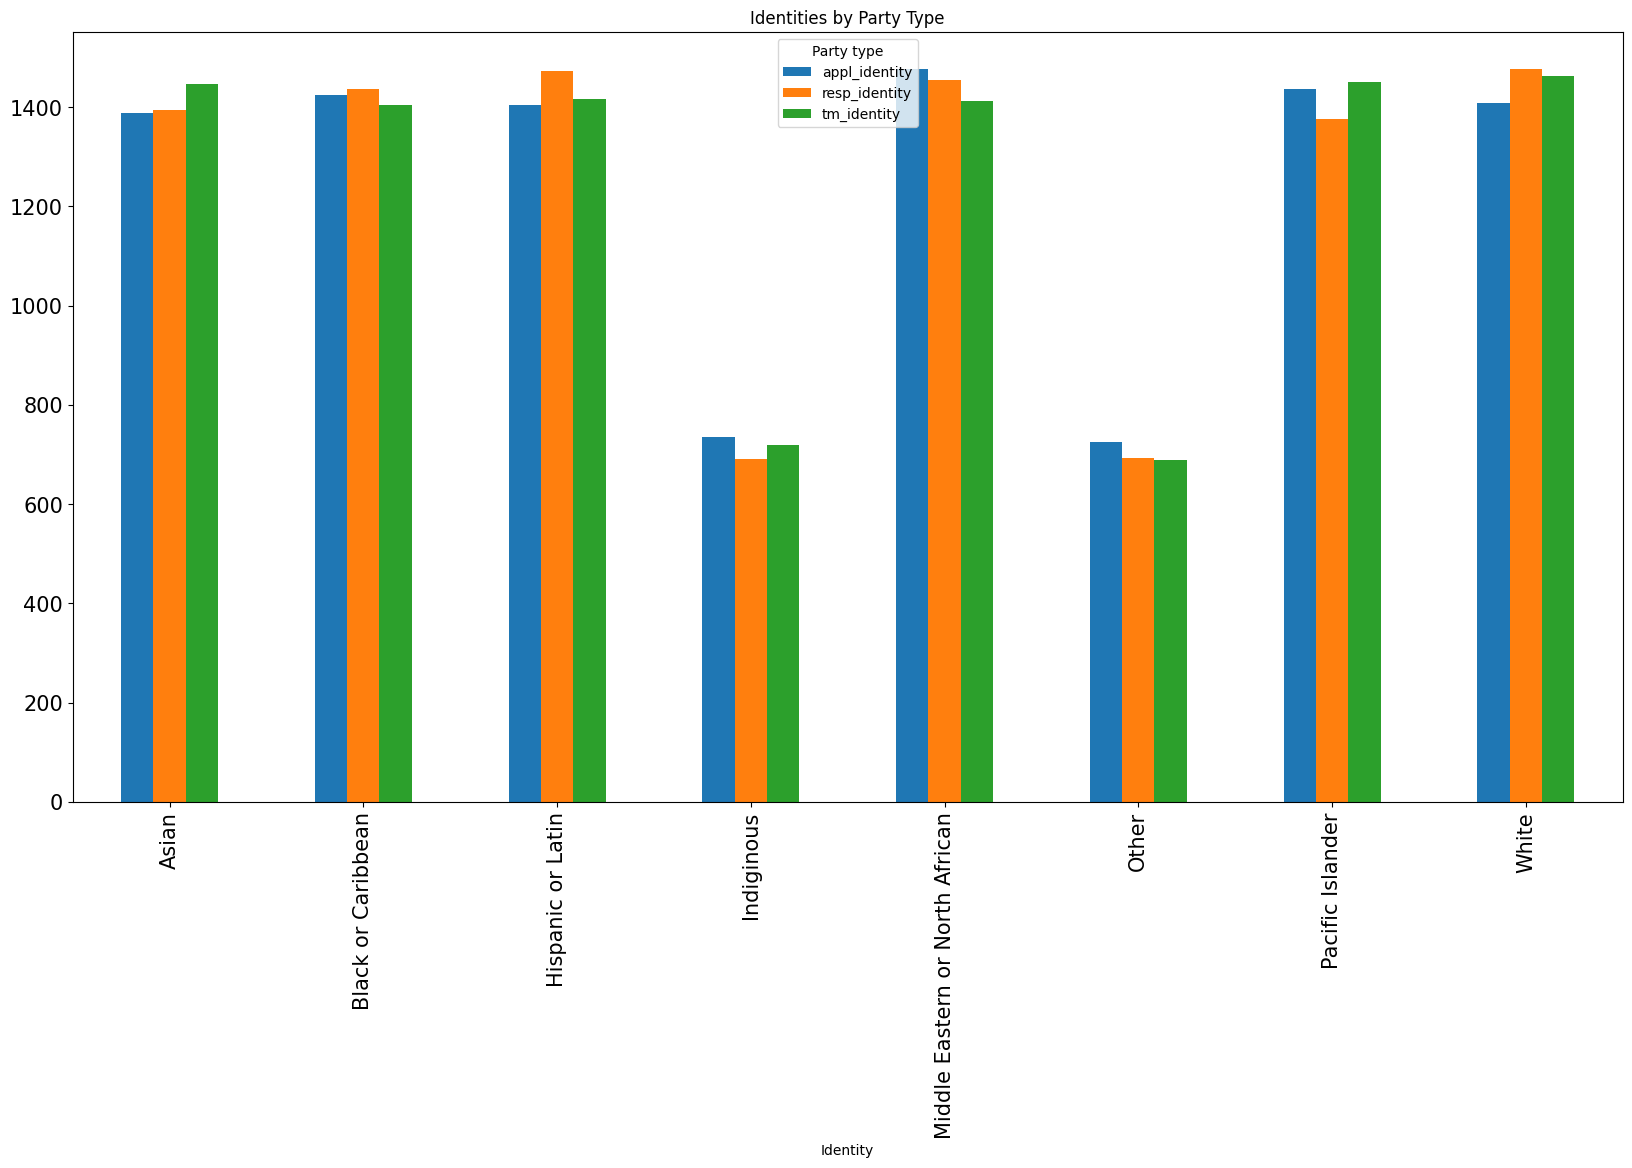

In [15]:
# Let's visualize the identity data
# This was not straightforward to do as I wanted to compare 3 columns 
# with the same values but I need to retain the value counts per each type of party/judge
# This article held the best solution I could find: https://stackoverflow.com/questions/32589829/how-to-get-value-counts-for-multiple-columns-at-once-in-pandas-dataframe
df2 = df.loc[:,["appl_identity","resp_identity","tm_identity"]]
df2 = df2.melt(var_name="Party type", value_name="Identity")
identities = pd.crosstab(index=df2["Identity"], columns=df2["Party type"])
identities.plot(kind="bar", figsize=(20,10),fontsize=15, title="Identities by Party Type");


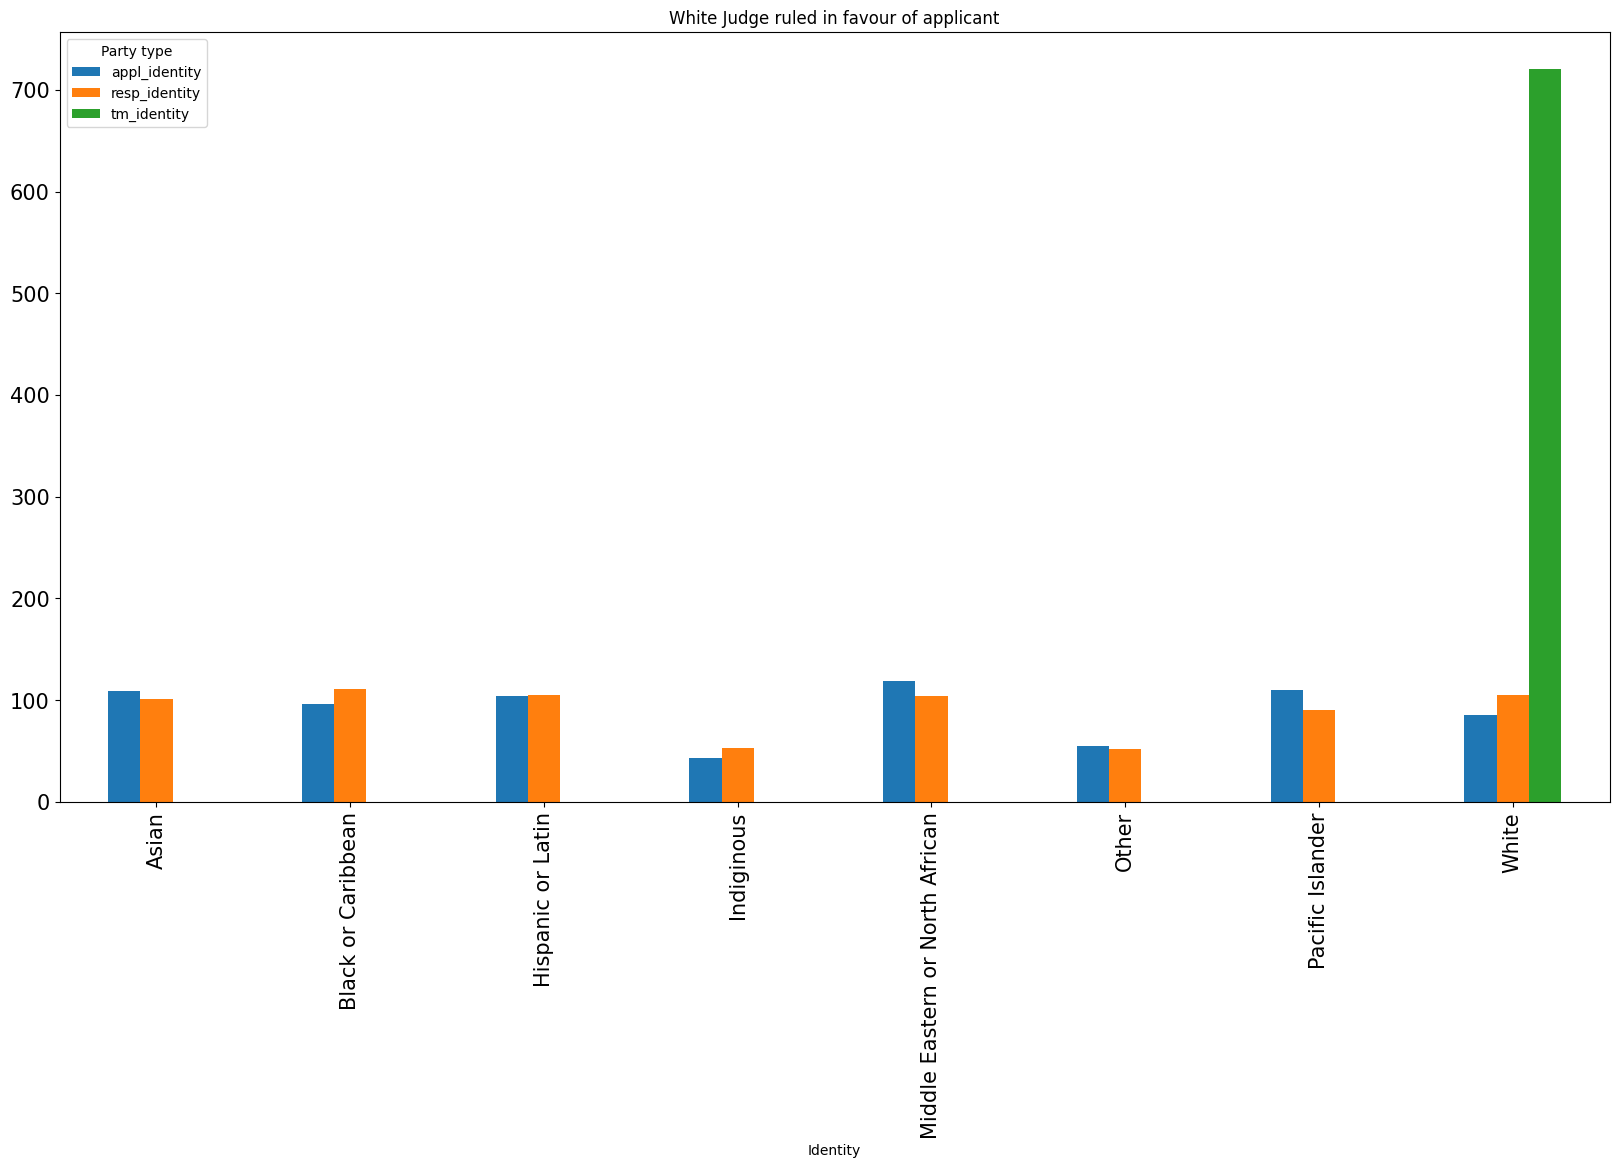

In [16]:
# Trying to isolate 'white' judges who 'ruled in favour of applicant'
df_temp1 = df.query('tm_identity == "White" and In_favour_of_Applicant == 1')
df_temp1 = df_temp1.loc[:,["appl_identity","resp_identity","tm_identity"]]
df_temp1 = df_temp1.melt(var_name="Party type", value_name="Identity")
identities = pd.crosstab(index=df_temp1["Identity"], columns=df_temp1["Party type"])
identities.plot(kind="bar", figsize=(20,10),fontsize=15, title="White Judge ruled in favour of applicant");

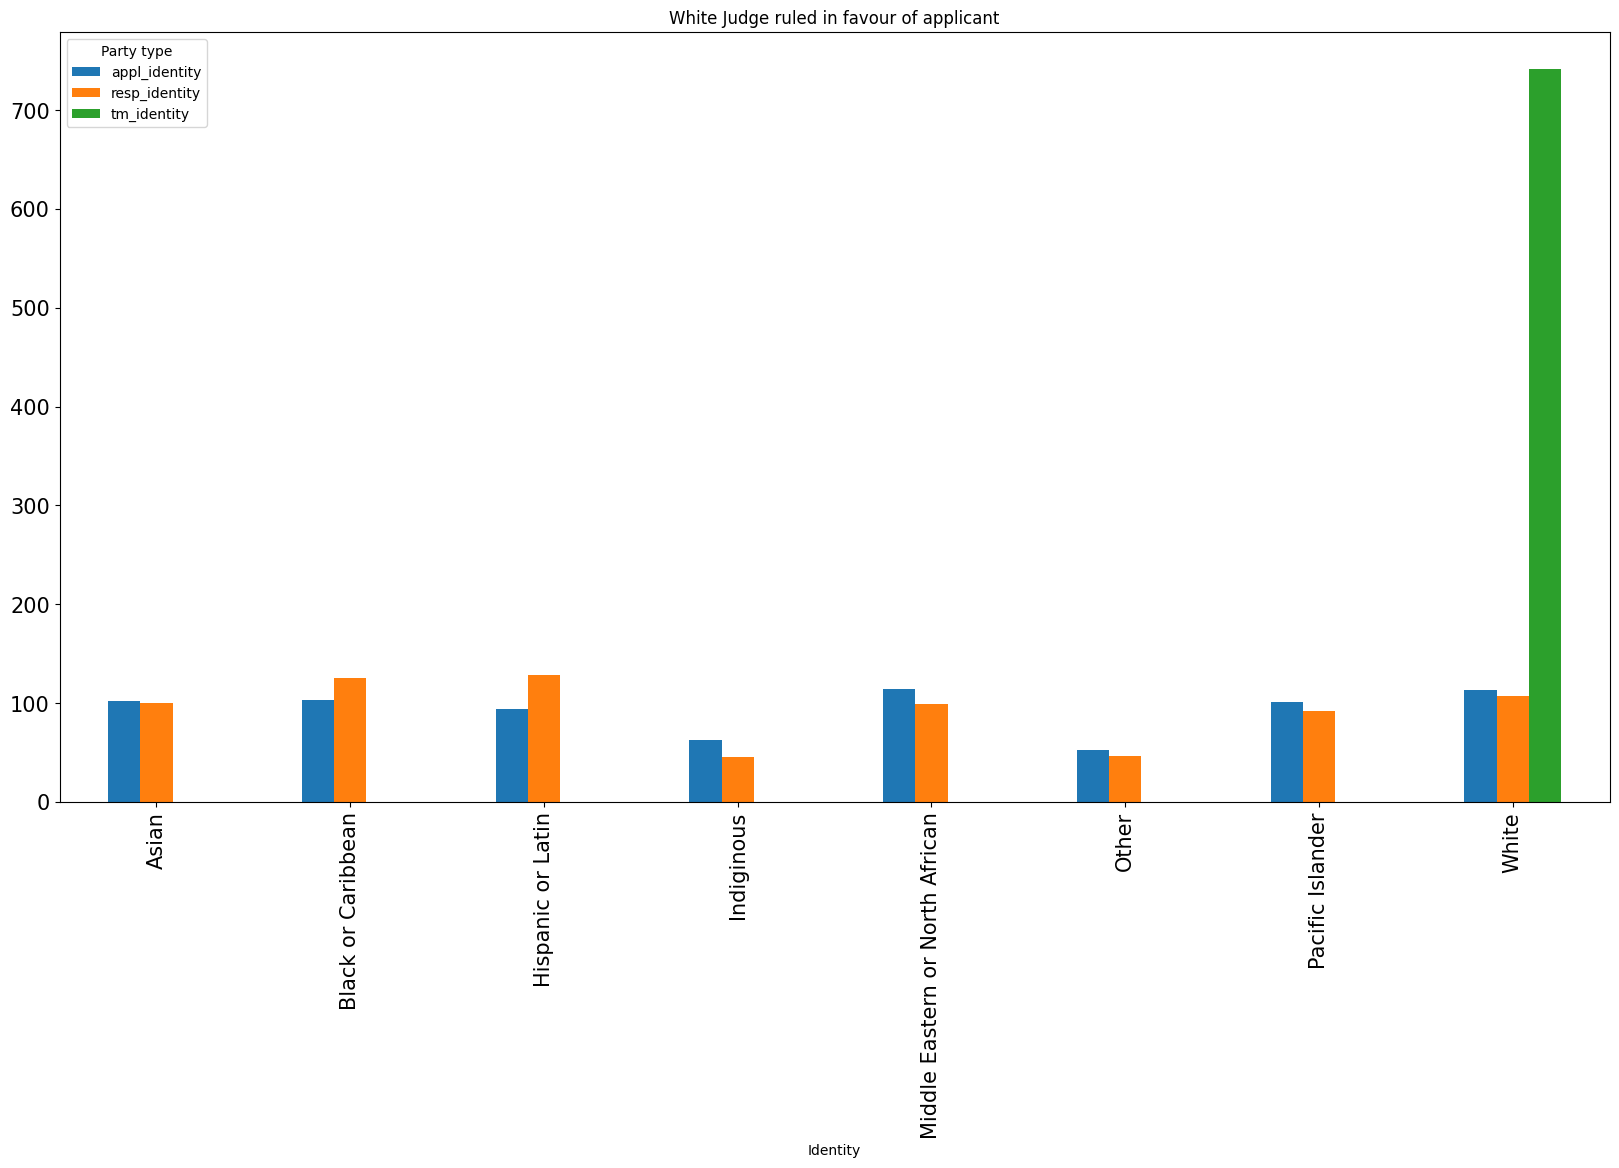

In [17]:
# Trying to isolate 'white' judges who DIDN'T 'ruled in favour of applicant'
df_temp1 = df.query('tm_identity == "White" and In_favour_of_Applicant == 0')
df_temp1 = df_temp1.loc[:,["appl_identity","resp_identity","tm_identity"]]
df_temp1 = df_temp1.melt(var_name="Party type", value_name="Identity")
identities = pd.crosstab(index=df_temp1["Identity"], columns=df_temp1["Party type"])
identities.plot(kind="bar", figsize=(20,10),fontsize=15, title="White Judge ruled in favour of applicant");

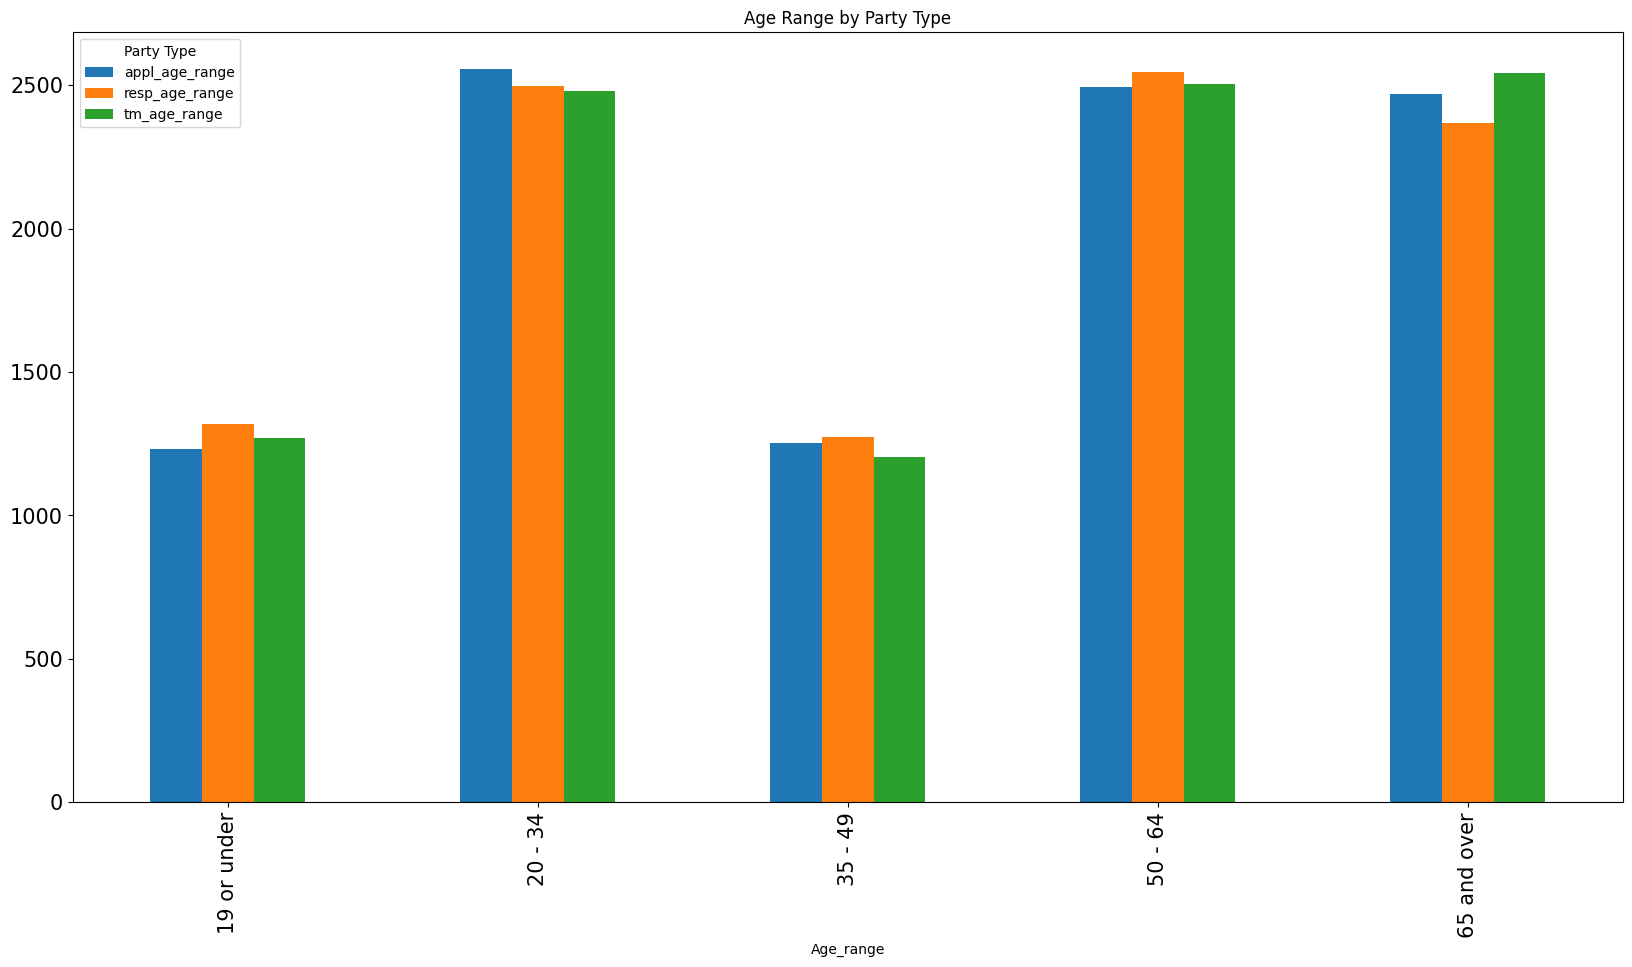

In [18]:
# Visualizing by age ranges
df3 = df.loc[:,["appl_age_range","resp_age_range","tm_age_range"]]
df3 = df3.melt(var_name="Party Type", value_name="Age_range")
age_ranges = pd.crosstab(index=df3["Age_range"], columns=df3["Party Type"])
age_ranges.plot(kind="bar", figsize=(20,10),fontsize=15, title="Age Range by Party Type");

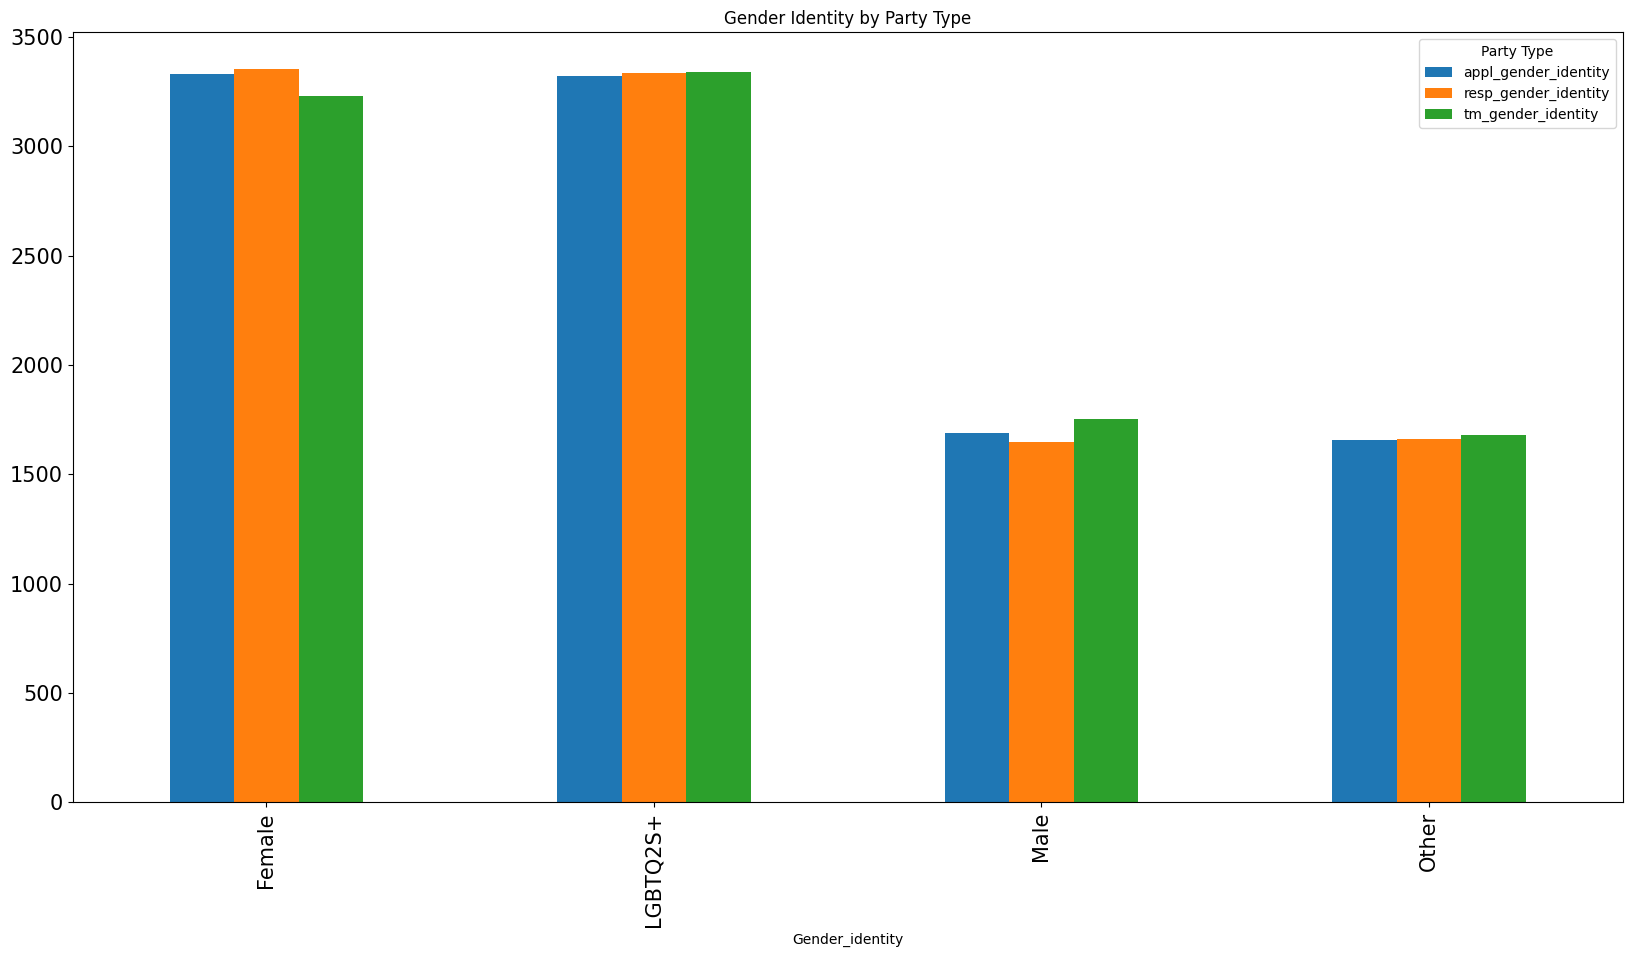

In [19]:
# Visualizing by gender identity
df4 = df.loc[:,["appl_gender_identity","resp_gender_identity","tm_gender_identity"]]
df4 = df4.melt(var_name="Party Type", value_name="Gender_identity")
gender_identities = pd.crosstab(index=df4["Gender_identity"], columns=df4["Party Type"])
gender_identities.plot(kind="bar", figsize=(20,10),fontsize=15, title="Gender Identity by Party Type");

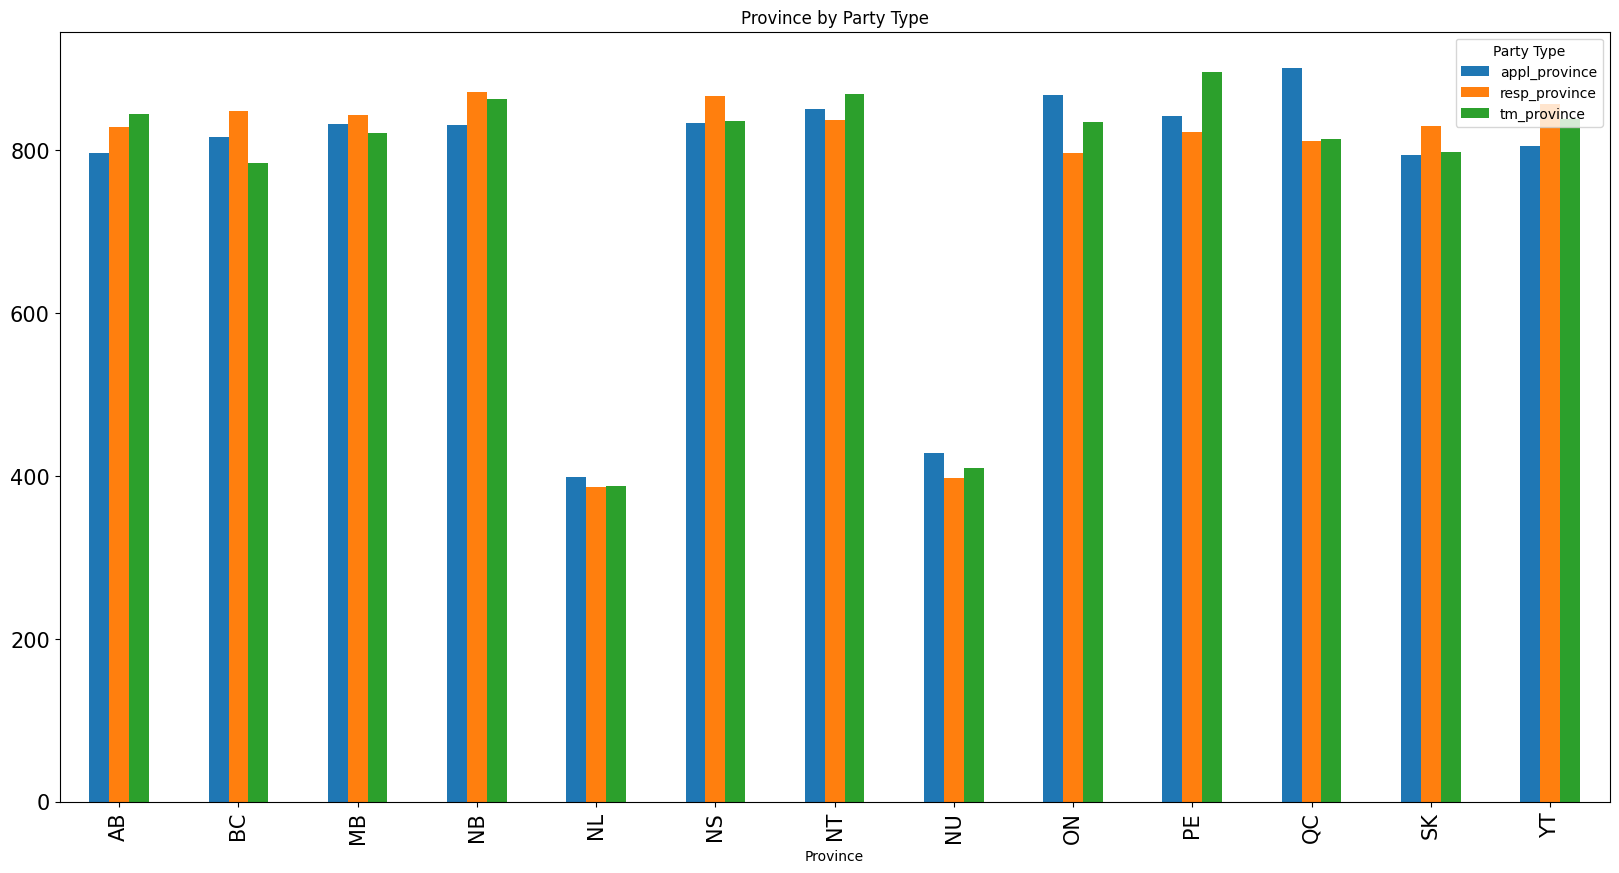

In [20]:
# Visualizing by Province
df5 = df.loc[:,["appl_province","resp_province","tm_province"]]
df5 = df5.melt(var_name="Party Type", value_name="Province")
provinces = pd.crosstab(index=df5["Province"], columns=df5["Party Type"])
provinces.plot(kind="bar", figsize=(20,10),fontsize=15, title="Province by Party Type");

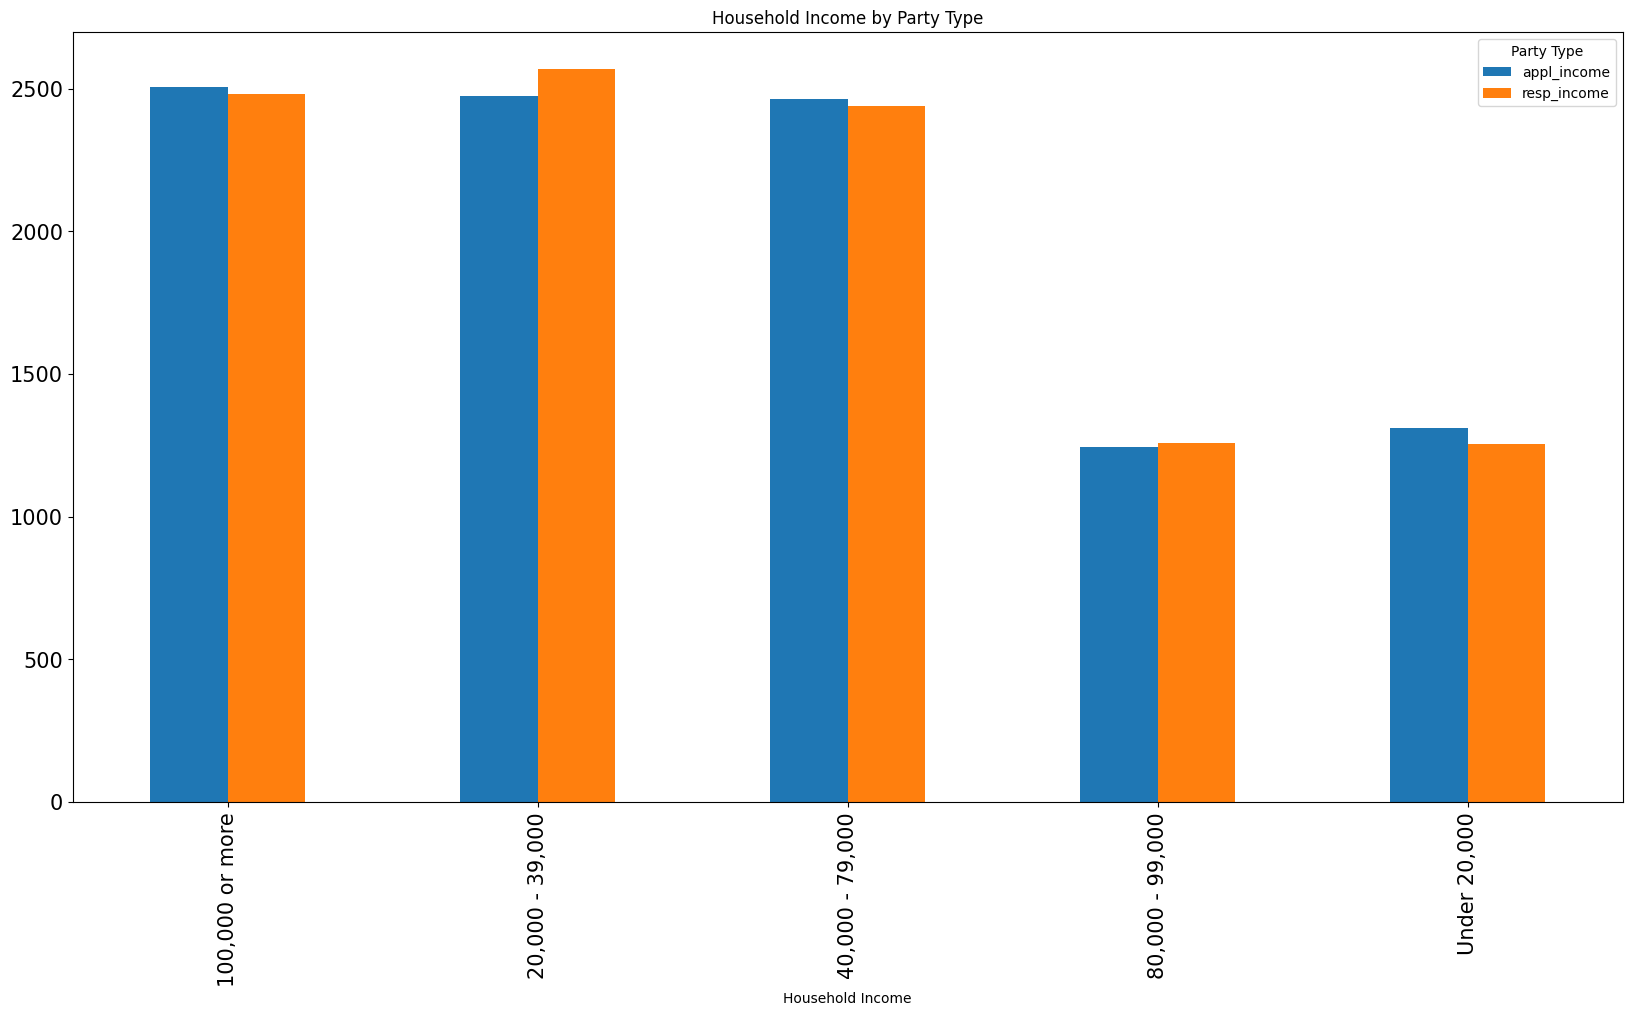

In [21]:
# Visualizing by Household Income
df6 = df.loc[:,["appl_income","resp_income"]]
df6 = df6.melt(var_name="Party Type", value_name="Household Income")
incomes = pd.crosstab(index=df6["Household Income"], columns=df6["Party Type"])
incomes.plot(kind="bar", figsize=(20,10),fontsize=15, title="Household Income by Party Type");


# Steps in modelling

The steps in modelling with TensorFlow are typically:

1. Create or import a model
2. Compile the model
3. Fit the model
4. Evaluate the model
5. Tweak
6. Evaluate... 

📓 Before creating a model we will have to convert all of the data to numeric values so that TensorFlow can operate on the data to find patterns. Pandas has a function to 'One Hot' encode our non-numeric data into numbers called `get_dummies`

In [22]:
# Let's look at how many columns we have before one_hot encoding the data
df.shape

(10000, 18)

Looks like 10,000 rows and 18 columns

In [23]:
demog_one_hot = pd.get_dummies(df)
demog_one_hot.head()

,appl_has_lawyer,resp_has_lawyer,In_favour_of_Applicant,dispute_type_employment,dispute_type_general small claim,dispute_type_goods or services,dispute_type_housing,dispute_type_loans and debts,dispute_type_personal injury,dispute_type_property dispute,dispute_type_residential contruction,dispute_type_strata,dispute_type_vehicle injury,appl_age_range_19 or under,appl_age_range_20 - 34,appl_age_range_35 - 49,appl_age_range_50 - 64,appl_age_range_65 and over,appl_identity_Asian,appl_identity_Black or Caribbean,appl_identity_Hispanic or Latin,appl_identity_Indiginous,appl_identity_Middle Eastern or North African,appl_identity_Other,appl_identity_Pacific Islander,appl_identity_White,appl_gender_identity_Female,appl_gender_identity_LGBTQ2S+,appl_gender_identity_Male,appl_gender_identity_Other,"appl_income_100,000 or more","appl_income_20,000 - 39,000","appl_income_40,000 - 79,000","appl_income_80,000 - 99,000","appl_income_Under 20,000",appl_province_AB,appl_province_BC,appl_province_MB,appl_province_NB,appl_province_NL,appl_province_NS,appl_province_NT,appl_province_NU,appl_province_ON,appl_province_PE,appl_province_QC,appl_province_SK,appl_province_YT,resp_age_range_19 or under,resp_age_range_20 - 34,resp_age_range_35 - 49,resp_age_range_50 - 64,resp_age_range_65 and over,resp_identity_Asian,resp_identity_Black or Caribbean,resp_identity_Hispanic or Latin,resp_identity_Indiginous,resp_identity_Middle Eastern or North African,resp_identity_Other,resp_identity_Pacific Islander,resp_identity_White,resp_gender_identity_Female,resp_gender_identity_LGBTQ2S+,resp_gender_identity_Male,resp_gender_identity_Other,"resp_income_100,000 or more","resp_income_20,000 - 39,000","resp_income_40,000 - 79,000","resp_income_80,000 - 99,000","resp_income_Under 20,000",resp_province_AB,resp_province_BC,resp_province_MB,resp_province_NB,resp_province_NL,resp_province_NS,resp_province_NT,resp_province_NU,resp_province_ON,resp_province_PE,resp_province_QC,resp_province_SK,resp_province_YT,tm_age_range_19 or under,tm_age_range_20 - 34,tm_age_range_35 - 49,tm_age_range_50 - 64,tm_age_range_65 and over,tm_identity_Asian,tm_identity_Black or Caribbean,tm_identity_Hispanic or Latin,tm_identity_Indiginous,tm_identity_Middle Eastern or North African,tm_identity_Other,tm_identity_Pacific Islander,tm_identity_White,tm_gender_identity_Female,tm_gender_identity_LGBTQ2S+,tm_gender_identity_Male,tm_gender_identity_Other,tm_province_AB,tm_province_BC,tm_province_MB,tm_province_NB,tm_province_NL,tm_province_NS,tm_province_NT,tm_province_NU,tm_province_ON,tm_province_PE,tm_province_QC,tm_province_SK,tm_province_YT
0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [24]:
# Let's look at how many columns we have after one_hot encoding the data
demog_one_hot.shape

(10000, 113)

Now there are 113 columns in the dataframe which makes sense as every set of values has to have a yes/no value, for example, for each party you will have a 'yes' for 1 out of 13 and the other 12 are essentially in the dataset row as 'no' for that particular party.

In [25]:
# Create the X & y values (features and labels)
X = demog_one_hot.drop("In_favour_of_Applicant", axis=1)
X.head()

,appl_has_lawyer,resp_has_lawyer,dispute_type_employment,dispute_type_general small claim,dispute_type_goods or services,dispute_type_housing,dispute_type_loans and debts,dispute_type_personal injury,dispute_type_property dispute,dispute_type_residential contruction,dispute_type_strata,dispute_type_vehicle injury,appl_age_range_19 or under,appl_age_range_20 - 34,appl_age_range_35 - 49,appl_age_range_50 - 64,appl_age_range_65 and over,appl_identity_Asian,appl_identity_Black or Caribbean,appl_identity_Hispanic or Latin,appl_identity_Indiginous,appl_identity_Middle Eastern or North African,appl_identity_Other,appl_identity_Pacific Islander,appl_identity_White,appl_gender_identity_Female,appl_gender_identity_LGBTQ2S+,appl_gender_identity_Male,appl_gender_identity_Other,"appl_income_100,000 or more","appl_income_20,000 - 39,000","appl_income_40,000 - 79,000","appl_income_80,000 - 99,000","appl_income_Under 20,000",appl_province_AB,appl_province_BC,appl_province_MB,appl_province_NB,appl_province_NL,appl_province_NS,appl_province_NT,appl_province_NU,appl_province_ON,appl_province_PE,appl_province_QC,appl_province_SK,appl_province_YT,resp_age_range_19 or under,resp_age_range_20 - 34,resp_age_range_35 - 49,resp_age_range_50 - 64,resp_age_range_65 and over,resp_identity_Asian,resp_identity_Black or Caribbean,resp_identity_Hispanic or Latin,resp_identity_Indiginous,resp_identity_Middle Eastern or North African,resp_identity_Other,resp_identity_Pacific Islander,resp_identity_White,resp_gender_identity_Female,resp_gender_identity_LGBTQ2S+,resp_gender_identity_Male,resp_gender_identity_Other,"resp_income_100,000 or more","resp_income_20,000 - 39,000","resp_income_40,000 - 79,000","resp_income_80,000 - 99,000","resp_income_Under 20,000",resp_province_AB,resp_province_BC,resp_province_MB,resp_province_NB,resp_province_NL,resp_province_NS,resp_province_NT,resp_province_NU,resp_province_ON,resp_province_PE,resp_province_QC,resp_province_SK,resp_province_YT,tm_age_range_19 or under,tm_age_range_20 - 34,tm_age_range_35 - 49,tm_age_range_50 - 64,tm_age_range_65 and over,tm_identity_Asian,tm_identity_Black or Caribbean,tm_identity_Hispanic or Latin,tm_identity_Indiginous,tm_identity_Middle Eastern or North African,tm_identity_Other,tm_identity_Pacific Islander,tm_identity_White,tm_gender_identity_Female,tm_gender_identity_LGBTQ2S+,tm_gender_identity_Male,tm_gender_identity_Other,tm_province_AB,tm_province_BC,tm_province_MB,tm_province_NB,tm_province_NL,tm_province_NS,tm_province_NT,tm_province_NU,tm_province_ON,tm_province_PE,tm_province_QC,tm_province_SK,tm_province_YT
0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


Now we have 1 less column as we dropped the column we want to predict from the dataset.

In [26]:
# This is the column we want to predict in the end.
y = demog_one_hot["In_favour_of_Applicant"]
y

0       0
1       1
2       0
3       1
4       1
       ..
9995    0
9996    1
9997    0
9998    0
9999    0
Name: In_favour_of_Applicant, Length: 10000, dtype: int64

## 1. Create the Model

In [27]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [28]:
# Split the data into train, validation and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.15, 
                                                    shuffle=True, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.17647,# 1500/8500 = .1765 (trying to get 15% of 10K) 
                                                  random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y val shape: {}".format(y_val.shape))


X_train shape: (7000, 112)
X_test shape: (1500, 112)
y_train shape: (7000,)
y_test shape: (1500,)
X_val shape: (1500, 112)
y val shape: (1500,)


In [29]:
# Set a random seed so that our experiments will remain consistent
tf.random.set_seed(42)

#1. Create a model with tf Sequential API
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(112),# Using 112 neurons since we have 112 columns
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

## 2. Compile the Model

In [30]:
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),# for binary classification
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



## 3. Fit the model

In [31]:
# history = model_1.fit(X,
#             y, 
#             epochs=100,
#             validation_data=(X_val,y_val))

In [32]:
# pd.DataFrame(history.history).plot()

In [33]:
# model_1.summary()

## 4. Evaluate the Model

In [34]:
# model_1.evaluate(X_test, y_test)

The first try results are not very good at around 50% accuracy. Let's adjust some parameters on different versions of the model (so we can track the progress)

For model_2 we will try to add another hidden layer

In [35]:
# Set a random seed so that our experiments will remain consistent
tf.random.set_seed(42)

#1. Create a model with tf Sequential API
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(112),# Using 112 neurons since we have 112 columns
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),# for binary classification
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# history = model_2.fit(X,
#             y, 
#             epochs=100,
#             validation_data=(X_val,y_val))

In [36]:
# model_2.evaluate(X_test, y_test)

Adding a second hidden layer did essentially nothing to change the accuracy or loss. Let's try changing the default activation functions to `relu` for input and hidden layers and `sigmoid` for the output layer. I did note in my research that for binary classification we need the output layer to be sigmoid. We will also remove the second hidden layer as that did not do anything to change the accuracy.

In [37]:
# Set a random seed so that our experiments will remain consistent
tf.random.set_seed(42)

#1. Create a model with tf Sequential API
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(112, activation="relu"),# Using 112 neurons since we have 112 columns
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),# for binary classification
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history = model_3.fit(X,
            y, 
            epochs=50,
            validation_data=(X_val,y_val))

Epoch 1/50
313/313 [==============================] - 4s 7ms/step - loss: 0.6941 - accuracy: 0.4988 - val_loss: 0.6912 - val_accuracy: 0.5387
Epoch 2/50
313/313 [==============================] - 1s 2ms/step - loss: 0.6896 - accuracy: 0.5242 - val_loss: 0.6819 - val_accuracy: 0.5813
Epoch 3/50
313/313 [==============================] - 1s 3ms/step - loss: 0.6830 - accuracy: 0.5467 - val_loss: 0.6670 - val_accuracy: 0.5993
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: 0.6716 - accuracy: 0.5709 - val_loss: 0.6574 - val_accuracy: 0.5987
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: 0.6566 - accuracy: 0.6040 - val_loss: 0.6345 - val_accuracy: 0.6593
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 0.6380 - accuracy: 0.6329 - val_loss: 0.6116 - val_accuracy: 0.6840
Epoch 7/50
313/313 [==============================] - 1s 2ms/step - loss: 0.6143 - accuracy: 0.6624 - val_loss: 0.5811 - val_accuracy: 0.7160
Epoch 

Adding the `relu` and `sigmoid` activation functions to the input, hidden and output layers respectively vastly improved the outcome. In fact, the accuracy is 1.000 which is the highest possible score. This could actually not be a good thing as the model may be overfitting. Let's look at the outcome by evaluating and looking at the history graph.

In [38]:
model_3.evaluate(X_test, y_test)

47/47 [==============================] - 0s 1ms/step - loss: 0.0101 - accuracy: 0.9987


[0.010092847049236298, 0.9986666440963745]

<Axes: >

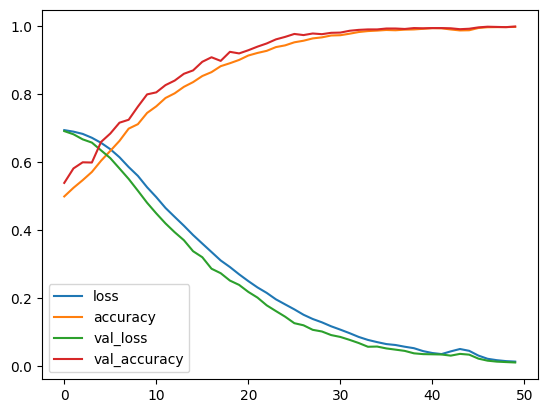

In [39]:
pd.DataFrame(history.history).plot()


From this graph we may be able to infer that it reached optimal accuracy around 45 epochs and just went in regular cycles after that of getting a bit worse but then back to optimal. So we can probably decrease the epochs to 45 going forward. This will decrease unnecessary resource consumption.

Since we seem to have a model operating at the best possible accuracy we should try to make some predictions.

In [40]:
y_preds = model_3.predict(X_test)

confusion_matrix(y_test, tf.round(y_preds))

array([[715,   1],
       [  1, 783]])

Let's try with only 45 epochs to see the results.

In [41]:
#1. Create a model with tf Sequential API
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(112, activation="relu"),# Using 112 neurons since we have 112 columns
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),# for binary classification
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history = model_4.fit(X,
            y, 
            epochs=45,
            validation_data=(X_val,y_val))

Epoch 1/45
313/313 [==============================] - 1s 3ms/step - loss: 0.6954 - accuracy: 0.5014 - val_loss: 0.6896 - val_accuracy: 0.5427
Epoch 2/45
313/313 [==============================] - 1s 3ms/step - loss: 0.6896 - accuracy: 0.5287 - val_loss: 0.6814 - val_accuracy: 0.5907
Epoch 3/45
313/313 [==============================] - 1s 4ms/step - loss: 0.6824 - accuracy: 0.5576 - val_loss: 0.6599 - val_accuracy: 0.6147
Epoch 4/45
313/313 [==============================] - 1s 4ms/step - loss: 0.6703 - accuracy: 0.5808 - val_loss: 0.6447 - val_accuracy: 0.6553
Epoch 5/45
313/313 [==============================] - 1s 4ms/step - loss: 0.6538 - accuracy: 0.6116 - val_loss: 0.6191 - val_accuracy: 0.6940
Epoch 6/45
313/313 [==============================] - 1s 4ms/step - loss: 0.6340 - accuracy: 0.6441 - val_loss: 0.5973 - val_accuracy: 0.7027
Epoch 7/45
313/313 [==============================] - 1s 4ms/step - loss: 0.6098 - accuracy: 0.6673 - val_loss: 0.5577 - val_accuracy: 0.7533
Epoch 

So not exactly  a score of `1` for accuracy but that's maybe not a bad thing as we were probably overfitting before.

In [42]:
model_4.evaluate(X_test, y_test)

47/47 [==============================] - 0s 2ms/step - loss: 0.0462 - accuracy: 0.9867


[0.04619034379720688, 0.9866666793823242]

<Axes: >

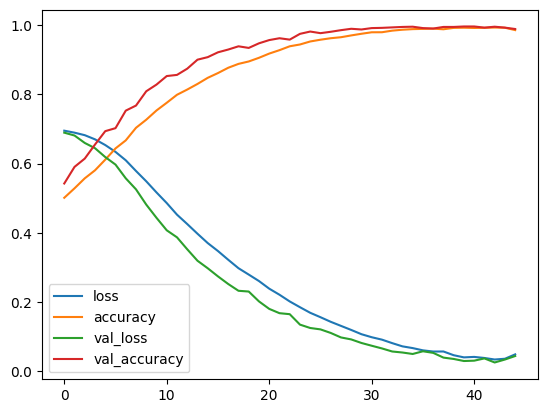

In [43]:
pd.DataFrame(history.history).plot()


In [44]:
y_preds = model_4.predict(X_test)
rounded_preds = tf.round(y_preds)
rounded_preds


<tf.Tensor: shape=(1500, 1), dtype=float32, numpy=
array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)>

In [45]:
confusion_matrix(y_test, tf.round(y_preds))

array([[707,   9],
       [ 11, 773]])

# Saving the model for export

In [46]:
model_4.save("current_digi_justice_model.h5")

# Side tangent - one hot encoding a single row for prediction.
Since we are making prediction on a single set of demographic values, using the conventional one_hot_encoding methods will not work as the code won't see all the possible values and therefore the shape of the data won't be what the tensorflow model is expecting. 
Let's play around with how we can take our values and using dictionaries perform a 'psuedo one_hot_encoding'

In [47]:
demog_one_hot['appl_age_range_19 or under'][0]

1

In [48]:
# Just building a string to export all the columns names for use in Azure function
df_columns = demog_one_hot.columns
str_res = ""
for x in df_columns:
  str_res  = str_res+":::"+ x

print(str_res)


:::appl_has_lawyer:::resp_has_lawyer:::In_favour_of_Applicant:::dispute_type_employment:::dispute_type_general small claim:::dispute_type_goods or services:::dispute_type_housing:::dispute_type_loans and debts:::dispute_type_personal injury:::dispute_type_property dispute:::dispute_type_residential contruction:::dispute_type_strata:::dispute_type_vehicle injury:::appl_age_range_19 or under:::appl_age_range_20 - 34:::appl_age_range_35 - 49:::appl_age_range_50 - 64:::appl_age_range_65 and over:::appl_identity_Asian:::appl_identity_Black or Caribbean:::appl_identity_Hispanic or Latin:::appl_identity_Indiginous:::appl_identity_Middle Eastern or North African:::appl_identity_Other:::appl_identity_Pacific Islander:::appl_identity_White:::appl_gender_identity_Female:::appl_gender_identity_LGBTQ2S+:::appl_gender_identity_Male:::appl_gender_identity_Other:::appl_income_100,000 or more:::appl_income_20,000 - 39,000:::appl_income_40,000 - 79,000:::appl_income_80,000 - 99,000:::appl_income_Under 2

**Next steps (pseudocode)**

- map the columns from a non-encoded data set to it's encoded value headers (list) in a dictionary
- in a FOR loop over the non-encoded data: fetch the list of encoded value headers using the non-encoded header value as the key. 
- in a nested FOR loop of the encoded header values, find the encoded header that ENDS WITH the actual data value from the non-encoded column (received from the web request)
- while looping through these values, everytime we don't find a match add a '0' to a new dataframe column with the encoded column header, if a match is found add a '1' with the column header to the dataframe - in other words, never break, iterate all values

📓 This is just a reminder for later when writing the code in the azure function

# Deeper analysis

In [49]:
model_4.layers

In [50]:
model_4.layers[1]

In [51]:
# Get the patterns of a layer in our network
weights, biases = model_4.layers[1].get_weights()

# Shapes
weights, weights.shape

(array([[ 3.2186991e-01,  1.2287811e-01, -4.1186374e-01, ...,
         -5.8205378e-01, -7.5188321e-01,  6.3822651e-01],
        [ 7.7120906e-01, -3.5038996e-01,  3.4309635e-01, ...,
         -1.3044947e-01, -1.9902018e-01, -5.1520801e-01],
        [-3.6551225e-01, -5.2862304e-01,  1.8950494e-02, ...,
          3.4160626e-01,  4.5452103e-01, -2.5607508e-01],
        ...,
        [-7.7967405e-02, -6.6040766e-01, -4.5192111e-02, ...,
          3.1256410e-01,  5.5009802e-04, -2.7760392e-01],
        [ 5.3595299e-01, -2.1730345e-01,  2.1398851e-01, ...,
          5.8530498e-01, -4.5924020e-01,  4.2854521e-01],
        [-4.6697009e-01,  3.9736416e-02,  7.5090170e-01, ...,
         -9.8721884e-02, -3.3627334e-01,  1.4663835e-02]], dtype=float32),
 (112, 10))

**Weights**: Each value in the weights matrix corresponds to how a particular value in the dataset SHOULD influence the network's decisions.
When the NN starts learning, the numbers in the weights matrix start out completely random. As the NN continues learning over time it will slowly update the numbers as it sees more examples and optimizes itself.

Biases: bias vector only has 1 value per hidden unit. every neuron has a bias vector. each of these is paired with a weights matrix.

The bias vector gets initialized as zeros, at least in the case of a tensorflow dense layer.

The bias vector dictates how much the patterns within the corresponding weights matrix should influence the next layer.

In [52]:
# Bias and biases shapes
biases, biases.shape

(array([0.04808598, 0.07697701, 0.07189409, 0.06960492, 0.076479  ,
        0.04851254, 0.07661407, 0.02642068, 0.03606821, 0.01163191],
       dtype=float32),
 (10,))

In [53]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 112)               12656     
                                                                 
 dense_11 (Dense)            (None, 10)                1130      
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 13,797
Trainable params: 13,797
Non-trainable params: 0
_________________________________________________________________


In [54]:
(112 * 112) + 1130 + 11

13685

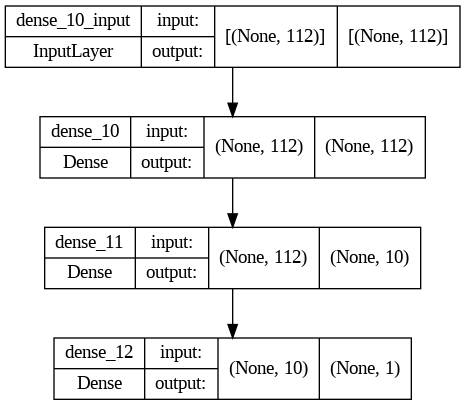

In [55]:
# Let's check out another way of viewing our deep learning models
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)